## data visualization

In [1]:
import os
os.chdir("/Users/admin/PycharmProjects/pythonProject/tabular-nov")

In [5]:
import numpy as np # Linear algebra.
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv).
import datatable as dt # Data processing, CSV file I/O (e.g. dt.fread).

import seaborn as sns # Visualization.
import matplotlib.pyplot as plt # Visualization.

# Machine Learning block.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline

from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

print(f'\n[INFO] Libraries set up has been completed.')


[INFO] Libraries set up has been completed.


In [4]:
df_train = dt.fread('./train.csv').to_pandas()
df_test = dt.fread('./test.csv').to_pandas()
submission2 = pd.read_csv('./sample_submission.csv')

df_train['target'] = df_train['target'].astype('int32') # Datatable reads target as bool by default. // data 저장 공간을 줄이기 위해 32 bit를 사용함.
print(f'{df_train.info()}\n\n')
df_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 102 entries, id to target
dtypes: float64(100), int32(2)
memory usage: 462.3 MB
None




,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
0,0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,...,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,...,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,...,4.88300,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.14112,0.124464,0.148209,0


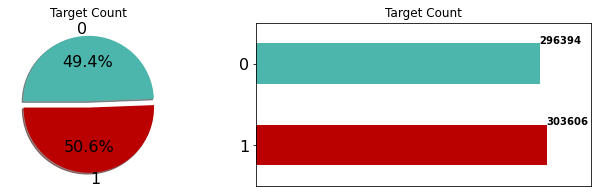

In [12]:
df_target_count = df_train.target.value_counts()

f, axes = plt.subplots(ncols=2, figsize=(12, 3))
plt.subplots_adjust(wspace=0)

df_target_count.plot.pie(
    ax=axes[0], autopct="%.1f%%", 
    explode=(0.05, 0.05),label='', 
    title='Target Count', fontsize=16,
    colors=['#BB0000', '#4DB6AC'], 
    shadow=True, startangle=180,   
)

df_target_count.plot.barh(
    ax=axes[1],
    title='Target Count',
    fontsize=16,
    color=['#BB0000', '#4DB6AC']
)

plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    labelbottom=False
)

for i, v in enumerate(df_target_count):
    axes[1].text(v, i+0.25, str(v), color='black', fontweight='bold')
    axes[1].set_xlim([1, 350000])

plt.show()

target의 비율이 well - balanced 되어있음을 알 수 있다.
visualizaiton에 앞서, 데이터의 개수가 너무 많기 때문에, seed 값을 부여하고 일부의 데이터만 추출해서 작업하자.

In [13]:
seed = 322
df_train_sample = df_train.sample(n=30000, random_state=seed)
df_test_sample = df_test.sample(n=30000, random_state=seed)
df_train_sample.drop(columns='id', inplace=True)
df_test_sample.drop(columns='id', inplace=True)

np.random.seed(seed) 
features_choice = np.random.choice(
    df_train_sample.keys()[1:-1], size=12, replace=False
)

df_sample_twelve = df_train_sample[sorted(features_choice.tolist()) + ['target']]
df_sample_twelve.head(3)

,f1,f11,f17,f18,f38,f39,f50,f54,f58,f72,f89,f99,target
302398,4.073070,4.63243,0.319695,1.325480,3.22762,0.090556,4.93767,0.099563,0.131454,0.358294,0.124227,0.090139,1
392830,3.399050,3.83679,1.024180,2.740900,1.11988,-0.031536,4.83911,2.241090,0.040757,-0.019165,0.000610,0.067721,1
176693,-0.068099,2.64040,3.463310,0.278672,1.01882,1.052690,5.35115,1.042200,0.102209,0.471472,0.141255,0.043583,1


In [14]:
# keys() 를 주면 columns를 list로 추출
df_train_sample.keys() 

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99',
       'target'],
      dtype='object', length=101)

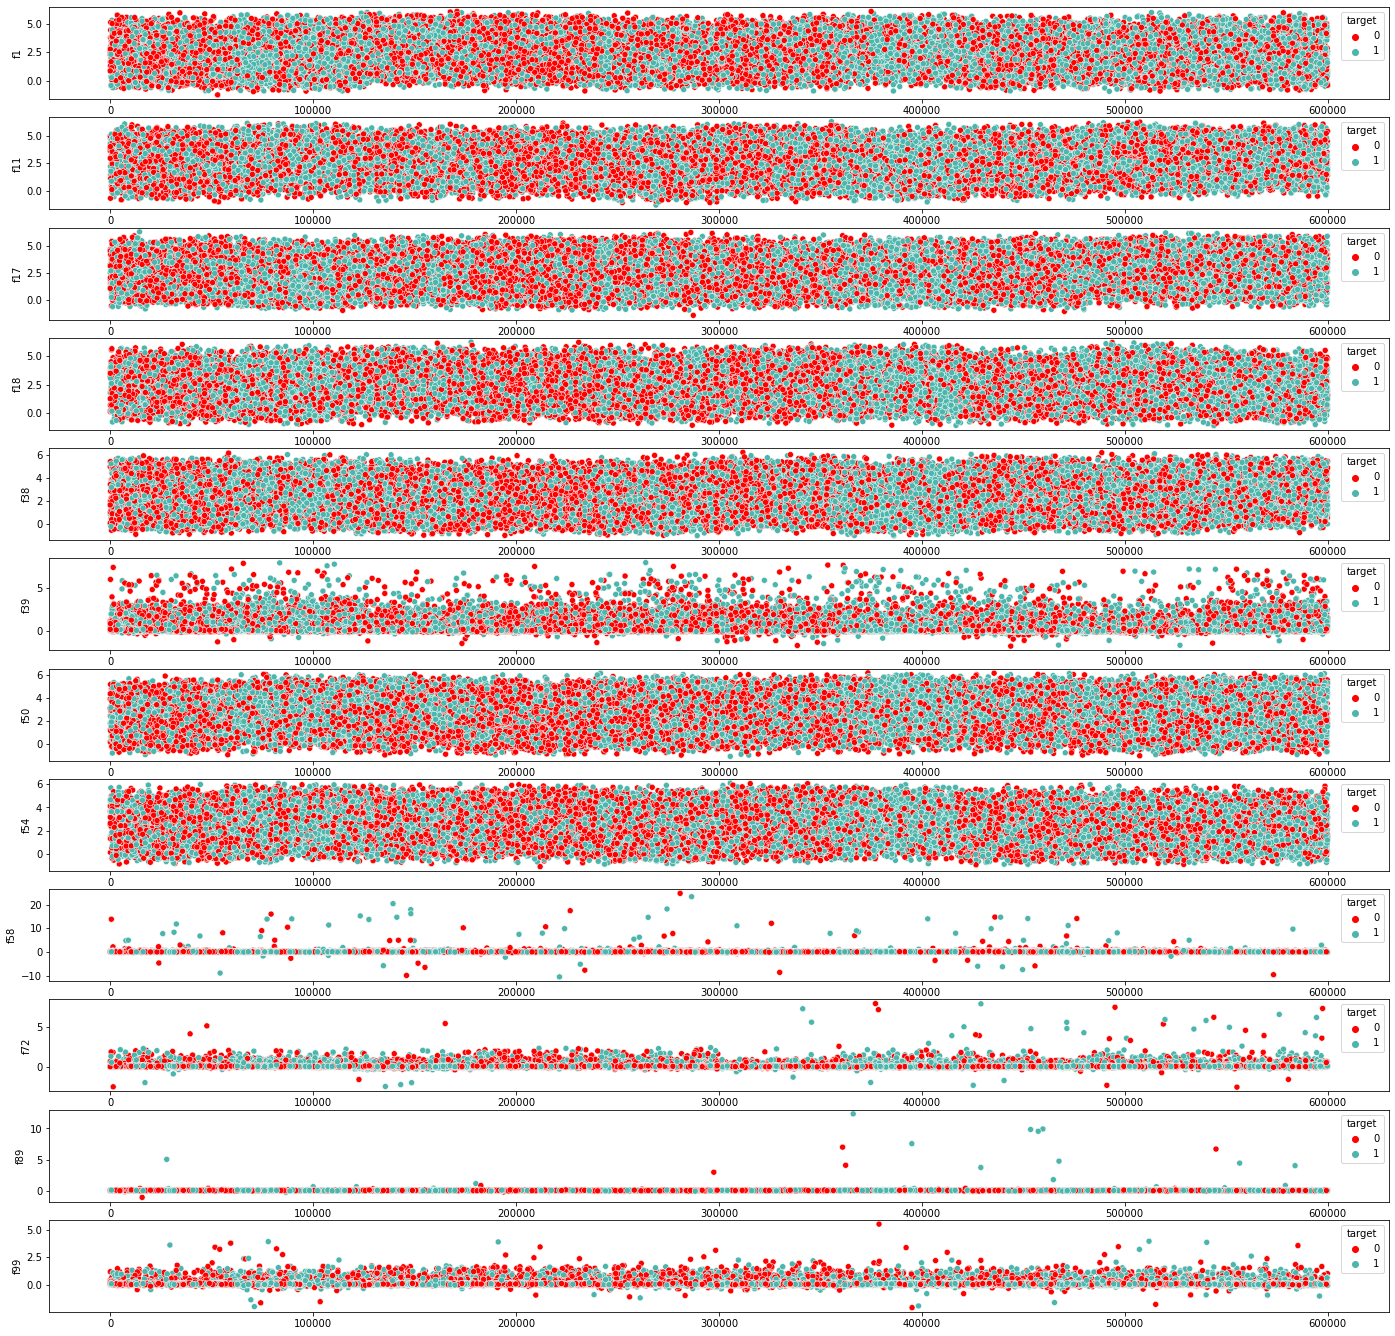

In [17]:
fig, ax = plt.subplots(nrows=12, figsize=(24, 24))

for i, feature in enumerate(sorted(features_choice)):
     sns.scatterplot(
         data=df_sample_twelve,
         x=df_sample_twelve.index,
         y=feature,
         hue='target',
         palette=['red', '#4DB6AC'],
         legend=True,
         ax=ax[i]
     )        

임의로 선택된 feature들의 분포와 scale이 모두 다르다는 것을 알 수 있다.

## Data Preprocessing

### Handle Missing Values

In [19]:
missing_values_train = df_train.isna().any().sum()
missing_values_test = df_test.isna().any().sum()

print(f'\n[INFO] {missing_values_train} missing value(s) has/have been detected in the train dataset.')
print(f'\n[INFO] {missing_values_test} missing value(s) has/have been detected in the test dataset.')


[INFO] 0 missing value(s) has/have been detected in the train dataset.

[INFO] 0 missing value(s) has/have been detected in the test dataset.


### Missing Values, how to handle

* **Option 1: Fill NaN with Outlier or Zero**

In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

* **Option 2: Fill NaN with Mean Value**

Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

* **Option 3: Fill NaN with Last Value with .ffill()**

Filling NaNs with the last value could be bit better.

* **Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()**

Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring values.

In [21]:
### Smoothing, reformating, Dropping

In [22]:
df_train.drop(columns='id', inplace=True)
df_train.head(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
0,0.106643,3.59437,132.8040,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,...,1.09862,0.013331,-0.011715,0.052759,0.065400,4.211250,1.97877,0.085974,0.240496,0
1,0.125021,1.67336,76.5336,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,...,3.46017,0.017054,0.124863,0.154064,0.606848,-0.267928,2.57786,-0.020877,0.024719,0
2,0.036330,1.49747,233.5460,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,...,4.88300,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.14112,0.124464,0.148209,0


In [23]:
df_test.drop(columns='id', inplace=True)
df_test.head(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,0.003229,4.838660,585.529,2.28291,0.713180,3.90783,0.480696,1.48227,4.89181,0.056351,...,0.112910,1.07355,0.122149,0.086330,0.036010,0.010619,0.290343,1.89820,0.131533,0.012047
1,0.008602,0.505536,-100.099,3.01267,0.027199,1.19461,5.036620,2.51744,4.55389,0.063876,...,-0.020214,2.62234,0.123307,0.033063,0.123059,0.005771,-0.392923,3.68964,0.047418,0.120015
2,1.461000,2.437260,-112.964,3.54123,0.752338,4.33831,1.648080,4.69991,1.95025,0.005303,...,-0.011036,2.03018,-0.000426,0.084091,0.123605,0.499554,4.054650,3.33067,0.108843,0.064687


### Having noticed float64 and int64 dtypes, we'd like to try downcast the dataset size for the sake of faster computation:

In [25]:
memory_train = sum(df_train.memory_usage()) / 1e6
print(f'[INFO] Memory usage train_before: {memory_train:.2f} MB.')

memory_test = sum(df_test.memory_usage()) / 1e6
print(f'[INFO] Memory usage test_before: {memory_test:.2f} MB.\n')

# Downcasting the traind dataset.
for col in df_train.columns:
    
    if df_train[col].dtype == "float64":
        df_train[col] = pd.to_numeric(df_train[col], downcast="float")
        
    if df_train[col].dtype == "int64":
        df_train[col] = pd.to_numeric(df_train[col], downcast="integer")
        
# Downcasting the test dataset.
for col in df_test.columns:
    
    if df_test[col].dtype == "float64":
        df_test[col] = pd.to_numeric(df_test[col], downcast="float")
        
    if df_test[col].dtype == "int64":
        df_test[col] = pd.to_numeric(df_test[col], downcast="integer")
        
memory_train = sum(df_train.memory_usage()) / 1e6
print(f'[INFO] Memory usage train: {memory_train:.2f} MB.')

memory_test = sum(df_test.memory_usage()) / 1e6
print(f'[INFO] Memory usage test: {memory_test:.2f} MB.')

[INFO] Memory usage train_before: 242.40 MB.
[INFO] Memory usage test_before: 216.00 MB.

[INFO] Memory usage train: 242.40 MB.
[INFO] Memory usage test: 216.00 MB.


## EDA

The problem statement of this competition says that the features are anonymized. In reality, there are not many things we can observe and make decisions on. Let's take a closer look at the distribution of the features:

In [26]:
df_train.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                     .head(15)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')


## \ 를 써서 줄을 아래로 내리지만 코드는 계속 연결되게 할 수 있다.

,count,mean,std,min,25%,50%,75%,max
f2,600000.000000,306.640411,551.701843,-1842.530029,43.573400,133.626007,302.262238,6119.279785
f35,600000.000000,55.698479,130.121475,-397.003998,6.671687,21.222700,48.320199,1464.469971
f44,600000.000000,3.227377,5.413137,-42.443199,1.010548,2.556800,4.214082,131.565002
f84,600000.000000,0.501983,2.363549,-9.791940,-0.067392,0.122185,0.325540,45.224701
f36,600000.000000,1.769525,1.785541,-2.888940,0.308010,1.441415,2.714502,13.029000
f50,600000.000000,2.558972,1.610904,-1.489400,1.213650,2.509860,3.940270,6.223770
f25,600000.000000,2.580079,1.609447,-1.380430,1.238715,2.524685,3.962772,6.192880
f10,600000.000000,2.580001,1.604273,-1.309730,1.205920,2.527070,3.956183,6.508760
f17,600000.000000,2.483061,1.577335,-1.387720,1.132498,2.504525,3.775860,6.377910
f80,600000.000000,2.550209,1.576663,-1.142840,1.236540,2.544100,3.864592,6.388890


std 기준으로 상위 3개의 변수에 대해서만 표준편차가 매우 크다는 것을 알 수 있다. 더불어 평균의 값 또한 더 크다.

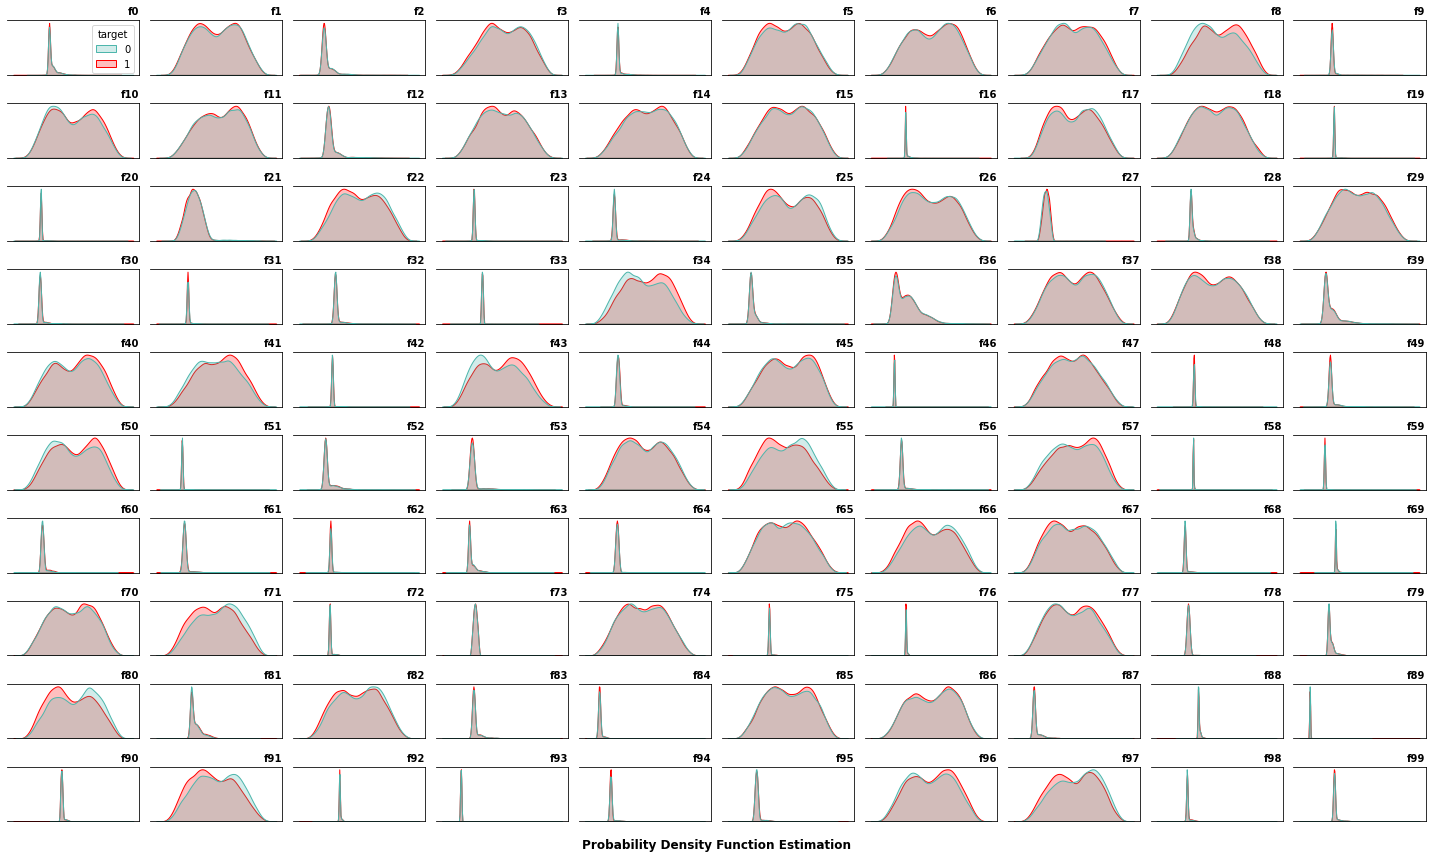

In [34]:
fig, axes = plt.subplots(10,10, figsize=(20, 12))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    
    sns.kdeplot(
        data=df_train_sample, ax=ax, hue='target', fill=True,
        x=f'f{idx}', palette=['#4DB6AC', 'red'], legend=idx==0
    )
 
    ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel('')
    ax.set_ylabel(''); ax.spines['left'].set_visible(False)
    ax.set_title(f'f{idx}', loc='right', weight='bold', fontsize=10)

fig.supxlabel('Probability Density Function Estimation', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

kdeplot 을 통해 그려본 결과, 몇몇은 bell shape이지만 또 몇몇은 매우 뾰족한 분포를 가지고 있다 => transformation 이 필요할 것이다.

이제 correlation 분포를 살펴보자

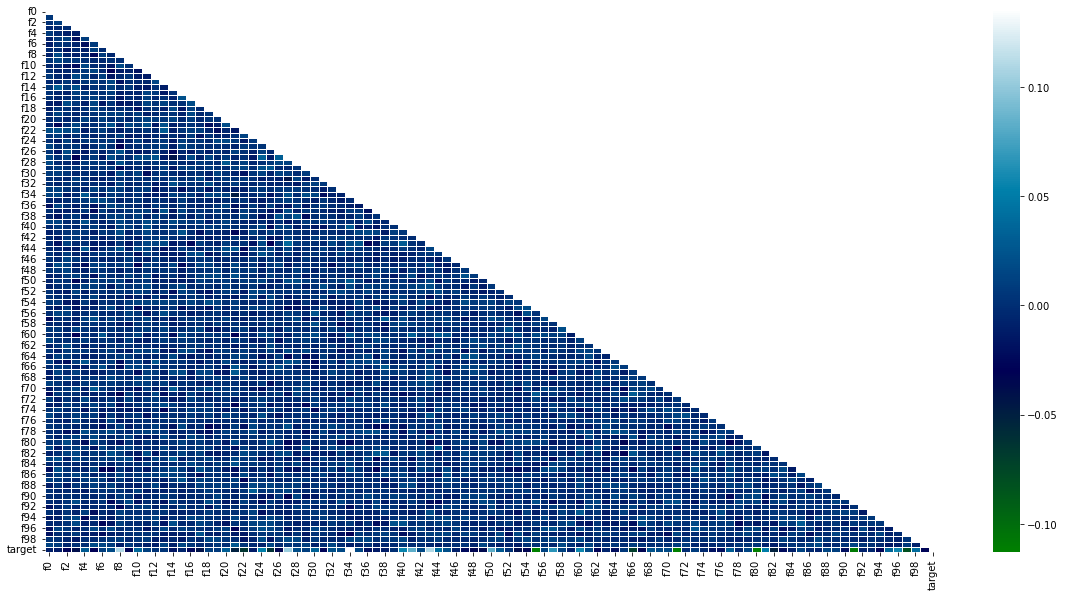

In [35]:
corr = df_train_sample.corr()

fig, axes = plt.subplots(figsize=(20, 10))
mask = np.zeros_like(corr)  # 하삼각행렬로 corr 나타내기.
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5, cmap='ocean')

plt.show()

## Feature Engineering
EDA에서 나왔던 결과들을 생각하면서 데이터를 변형시켜보자.

In [36]:
candles = [
    'f0','f2','f4','f9','f12','f16','f19','f20','f23','f24','f27',
    'f28','f30','f31','f32','f33','f35','f39','f42','f44','f46','f48',
    'f49','f51','f52','f53','f56','f58','f59','f60','f61','f62','f63',
    'f64','f68','f69','f72','f73','f75','f76','f78','f79','f81','f83',
    'f84','f87','f88','f89','f90','f92','f93','f94','f95','f98','f99'
]

df_candles_log_transform = df_train_sample[candles]

mask_neg = (df_candles_log_transform < 0)
mask_pos = (df_candles_log_transform > 0)

df_candles_log_transform[mask_neg] = np.log(np.abs(df_candles_log_transform)) * (-1)
df_candles_log_transform[mask_pos] = np.log(df_candles_log_transform)

In [37]:
df_candles_log_transform.describe().T.sort_values(by='std', ascending=False)\
                     .head(15)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

,count,mean,std,min,25%,50%,75%,max
f2,30000.000000,3.876170,3.299615,-7.146331,3.772912,4.893910,5.691927,8.699843
f31,30000.000000,-1.332219,3.089279,-12.658265,-3.170781,-2.461852,-0.277756,11.484620
f75,30000.000000,-1.133876,2.972997,-11.665368,-3.001862,-2.265925,0.620724,11.235839
f46,30000.000000,-1.044701,2.970201,-12.482198,-2.878691,-2.157403,2.364124,16.610283
f59,30000.000000,-1.268121,2.967715,-12.839495,-2.986786,-2.305092,-1.551514,12.625365
f48,30000.000000,-1.722845,2.962355,-13.406897,-3.283681,-2.627997,-2.040961,13.493942
f23,30000.000000,-1.612153,2.934143,-12.641871,-3.221568,-2.550882,-1.846351,12.435098
f56,30000.000000,-0.761610,2.929348,-13.227863,-2.797335,-1.998761,2.194994,11.504541
f62,30000.000000,-1.457550,2.919683,-11.436020,-3.121675,-2.444089,-0.748311,11.181006
f68,30000.000000,-1.415305,2.905319,-12.528495,-3.097760,-2.408951,-0.481242,15.158577


std 기준으로 볼 때 std의 차이가 크게 줄었다고 할 수 있다.

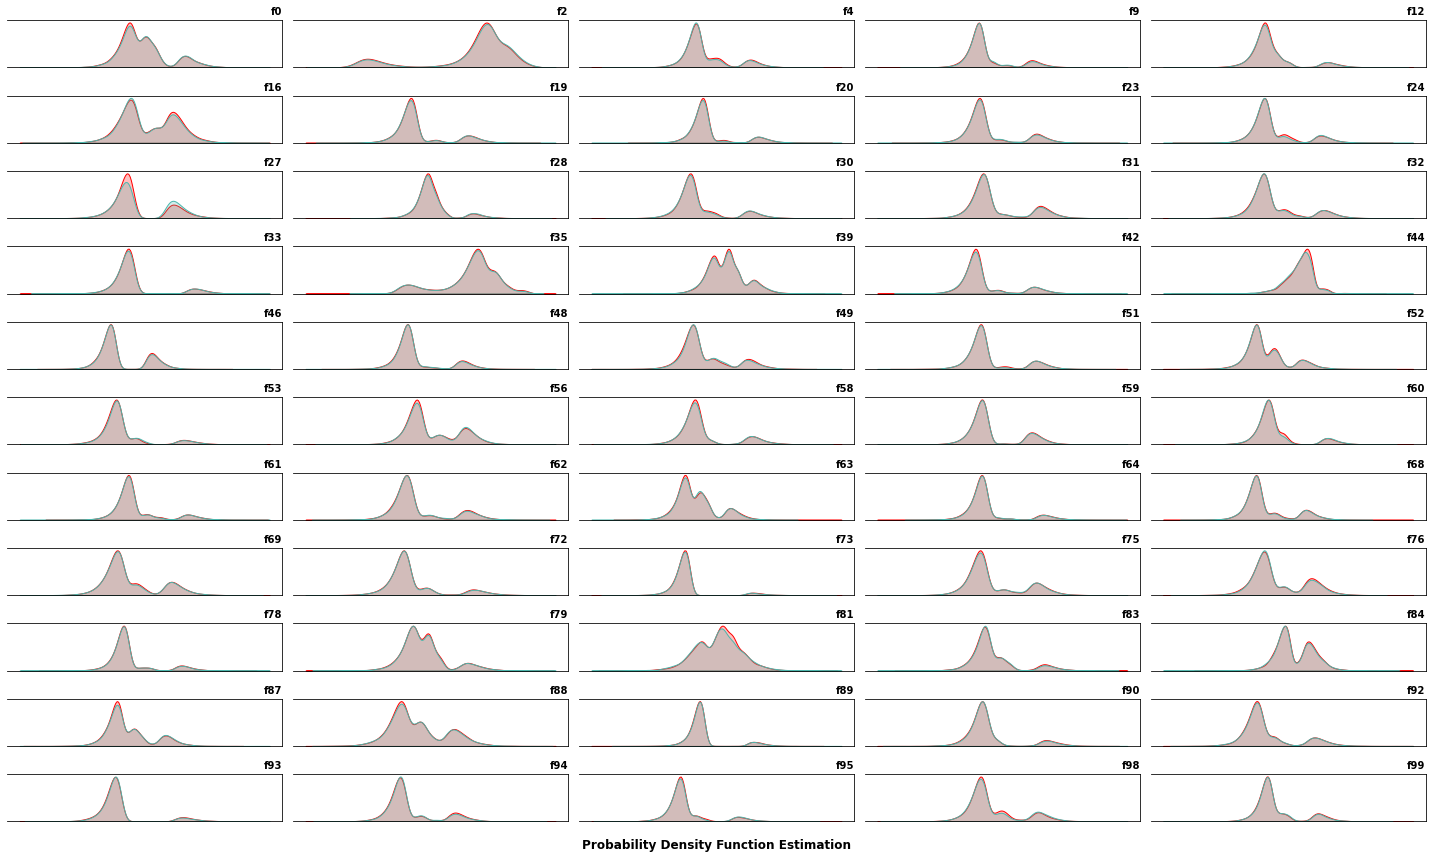

In [38]:
df_candles_log_transform['target'] = df_train_sample.target

fig, axes = plt.subplots(11,5, figsize=(20, 12))
axes = axes.flatten()

for col, ax in zip(candles, axes):
    
    sns.kdeplot(
        data=df_candles_log_transform, ax=ax, hue='target', fill=True,
        x=col, palette=['#4DB6AC', 'red'], legend=idx==0
    )
 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    ax.set_title(col, loc='right', weight='bold', fontsize=10)

fig.supxlabel('Probability Density Function Estimation', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

## Creating Aggregate Feature

to check multicolinearity

In [44]:
agg_features = ['sum','mean','std','max','min','kurt']
features = df_train.keys().tolist()[:-1]

for ft in agg_features:
    
    class_method = getattr(pd.DataFrame, ft)
    df_train_sample[ft] = class_method(df_train_sample[features], axis=1) #python에서 axis는 최종결과가 나올 때 어떻게 나올 것인지 고려하는 것
    ##axis=1이면 최종결과가 열로 나오는 것이므로, 데이터프레임의 행들을 다 더해서 mean std max 등을 행하게 될 것.
    df_test_sample[ft] = class_method(df_test_sample[features], axis=1)

df_train_sample.head(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f97,f98,f99,target,sum,mean,std,max,min,kurt
302398,0.000021,4.073070,117.42500,3.756700,0.065452,1.050720,3.83462,5.40726,4.698090,-0.041765,...,4.138780,-0.025209,0.090139,1,294.930355,2.949304,12.204035,117.4250,-0.702630,80.587446
392830,0.045159,3.399050,4417.16000,2.169670,1.419720,1.339530,4.47910,4.64566,1.854660,-0.055619,...,0.900841,0.048793,0.067721,1,4579.540258,45.795403,441.568010,4417.1600,-0.882491,99.985033
176693,0.570779,-0.068099,-8.21187,0.781223,0.104493,0.339191,5.14276,3.99444,0.307721,0.017088,...,3.132900,0.146997,0.043583,1,142.337016,1.423370,3.149388,25.8429,-8.211870,36.895472


In [ ]:
df_train.keys() # df 의 열 name을 뽑아냄.

In [43]:
df_train_sample.keys()

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f97', 'f98', 'f99', 'target', 'sum', 'mean', 'std', 'max', 'min',
       'kurt'],
      dtype='object', length=107)

### dropping feature

생략. 여기 데이터는 임의로 만든데이터이고 피처 중 어떤 것이 중요한 것인지 알기 어렵다.

## Modeling

> Now it is modeling time. There are many models to choose from. We are going to try following ones:
>
>* Logistic Regression
>* Linear SVC
>* Gaussian Naive Bayes
>* Stochastic Gradient Decent
>* XGB
>* TabNet

모델 적합에 앞서 helper function을 먼저 설정해서 코딩의 편의를 도모한다.

In [64]:
def print_shapes(X_train, y_train, X_valid, y_valid):
  """
  Prints shapes of train/valid splits.
  :param: X_train (numpy.ndarray)
  :param: y_train (numpy.ndarray)
  :param: X_valid(numpy.ndarray)
  :param: y_valid (numpy.ndarray)
  :return: None
  """

  print(f'\n[INFO] shape of X_train: {X_train.shape}.')
  print(f'[INFO] shape of y_train: {y_train.shape}.')
  print(f'[INFO] shape of X_valid: {X_valid.shape}.')
  print(f'[INFO] shape of y_valid: {y_valid.shape}.\n')


def auc_score(y_true, y_pred):
  """
  Prints shapes of train/valid splits.
  :param: y_true (numpy.ndarray)
  :param: y_pred (numpy.ndarray)
  :return: float
  """

  fpr, tpr, _ = roc_curve(y_true, y_pred)
  score = auc(fpr, tpr)

  return score


def train_model(x, y, clf, clf_name, xgb=False):
    """
    Trains model by using selected classifier.
    :param: x (scaled numpy.ndarray)
    :param: y (scaled numpy.ndarray)
    :param: clf (model classifier)
    :param: clf_name (str)
    :return: clf, float
    """
    
    best_clf_auc = 0

    for fold, (idx_train, idx_valid) in enumerate(skf.split(X, Y)):

            X_train, y_train = X[idx_train, :], Y[idx_train]
            X_valid, y_valid = X[idx_valid, :], Y[idx_valid]

            if fold == 0:
                print_shapes(X_train, y_train, X_valid, y_valid)
            
            if xgb:
                clf.fit(
                    X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    eval_metric='auc',
                    early_stopping_rounds=40,
                    verbose=100
                )
            else:
                clf.fit(X_train, y_train)

            y_pred = clf.predict_proba(X_valid)[:, 1]
            clf_auc = auc_score(y_true=y_valid, y_pred=y_pred)
            print(f'[INFO] Fold: {fold+1}. {clf_name} AUC score: {clf_auc:.6f}.')

            if clf_auc > best_clf_auc:
                best_clf = deepcopy(clf)
                best_clf_auc = clf_auc
    
    return best_clf, best_clf_auc

In [65]:
scaler = StandardScaler()
X = scaler.fit_transform(df_train[features])
Y = df_train.target.astype(dtype=int) # TabNet can save model only with int64.
X_test = scaler.transform(df_test[features]) ## 캐글 코드에는 fit_transform이라고 나와있는데, 내 생각엔 그냥 transform인듯?

In [66]:
seed = 1
epochs = 40
patience = 10
batch_size = 1024
lr = 0.02
n_folds = 5
skf = StratifiedKFold(
    n_splits=n_folds, 
    shuffle=True, 
    random_state=seed
)

## Logistic

In [52]:
lr_cfl = LogisticRegression(solver='liblinear')
clf_name = 'Logistic Regression'
best_lr_clf, best_lr_auc = train_model(x=X, y=Y, 
                                       clf=lr_cfl, clf_name=clf_name)


[INFO] shape of X_train: (480000, 100).
[INFO] shape of y_train: (480000,).
[INFO] shape of X_valid: (120000, 100).
[INFO] shape of y_valid: (120000,).

[INFO] Fold: 1. Logistic Regression AUC score: 0.749449.
[INFO] Fold: 2. Logistic Regression AUC score: 0.749373.
[INFO] Fold: 3. Logistic Regression AUC score: 0.749858.
[INFO] Fold: 4. Logistic Regression AUC score: 0.746990.
[INFO] Fold: 5. Logistic Regression AUC score: 0.749435.


In [53]:
df_coef = pd.DataFrame(features)
df_coef.columns = ['Feature']
df_coef["Coefficient"] = pd.Series(best_lr_clf.coef_[0])
df_coef.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
34,f34,0.266949
8,f8,0.225444
43,f43,0.215460
27,f27,0.202987
50,f50,0.163565
...,...,...
97,f97,-0.156410
71,f71,-0.205163
80,f80,-0.206439
91,f91,-0.215798


## 각 column feature를 하나하나 빼보면서 모델 설정하기

데이터가 너무 크기 때문에 편의를 위해 샘플 데이터를 가지고 작성!

In [57]:
scaler = StandardScaler()
X_sample = scaler.fit_transform(df_train_sample[features])
Y_sample = df_train_sample.target.astype(dtype=int) 
X_test_sample = scaler.transform(df_test_sample[features])

print(f'\n[INFO] shape of X: {X_sample.shape}.')
print(f'[INFO] shape of Y: {Y_sample.shape}.')

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_sample, Y_sample)

y_pred_logreg = logreg.predict_proba(X_sample)[:, 1]
score = auc_score(y_true=Y_sample, y_pred=y_pred_logreg)
print(f'\n[INFO] Logistic Regression AUC score: {score:.6f}.')


[INFO] shape of X: (30000, 100).
[INFO] shape of Y: (30000,).

[INFO] Logistic Regression AUC score: 0.752058.


In [58]:
benchmark = 0.752058
counter = 0
for idx, ft in enumerate(features):
            
    mask = df_train[features].columns != ft
    X_train = X_sample[:, mask]
    
    if idx == 0:
        print(f'\n[INFO] shape of X_train: {X_train.shape}\n')
    
    LogisticRegression(solver='liblinear')
    logreg.fit(X_train, Y_sample)
    
    
    y_pred = logreg.predict_proba(X_train)[:, 1]
    score = auc_score(y_true=Y_sample, y_pred=y_pred)
    
    if score >= benchmark:
        auc_old = benchmark
        benchmark = score
        print(
            f'\n[INFO] Iteration #: {idx}. AUC has been increased after dropping {ft} feature.\n'
            f'[INFO] Iteration #: {idx}. AUC before: {auc_old:.6f} >>> AUC after: {benchmark:.6f}.\n'
        )
    
    if idx % 10 == 0:
        print(f'[INFO] Iteration #: {idx}.')
        
    if score >= counter:
        
        counter = score
        print(f'[INFO] Iteration #: {idx}. AUC: {counter:.6f}. Removed feature: {ft}.')


[INFO] shape of X_train: (30000, 99)

[INFO] Iteration #: 0.
[INFO] Iteration #: 0. AUC: 0.751984. Removed feature: f0.
[INFO] Iteration #: 10.
[INFO] Iteration #: 12. AUC: 0.752038. Removed feature: f12.

[INFO] Iteration #: 13. AUC has been increased after dropping f13 feature.
[INFO] Iteration #: 13. AUC before: 0.752058 >>> AUC after: 0.752071.

[INFO] Iteration #: 13. AUC: 0.752071. Removed feature: f13.
[INFO] Iteration #: 20.
[INFO] Iteration #: 30.
[INFO] Iteration #: 40.
[INFO] Iteration #: 50.
[INFO] Iteration #: 60.
[INFO] Iteration #: 70.
[INFO] Iteration #: 80.
[INFO] Iteration #: 90.


## SVC

In [59]:
lr_svc = LinearSVC(dual=False, random_state=seed, tol=1e-4)
lr_svc = CalibratedClassifierCV(lr_svc) 
clf_name = 'Linear SVC'

best_svc_clf, best_svc_auc = train_model(x=X, y=Y, 
                                         clf=lr_svc, clf_name=clf_name)


[INFO] shape of X_train: (480000, 100).
[INFO] shape of y_train: (480000,).
[INFO] shape of X_valid: (120000, 100).
[INFO] shape of y_valid: (120000,).

[INFO] Fold: 1. Linear SVC AUC score: 0.749441.
[INFO] Fold: 2. Linear SVC AUC score: 0.749316.
[INFO] Fold: 3. Linear SVC AUC score: 0.749822.
[INFO] Fold: 4. Linear SVC AUC score: 0.746960.
[INFO] Fold: 5. Linear SVC AUC score: 0.749405.


### Gaussian Naive Bayes

In [60]:
nb_cfl = GaussianNB()
clf_name = 'Gaussian Naive Bayes'
best_nb_clf, best_nb_auc = train_model(x=X, y=Y, 
                                       clf=nb_cfl, clf_name=clf_name)


[INFO] shape of X_train: (480000, 100).
[INFO] shape of y_train: (480000,).
[INFO] shape of X_valid: (120000, 100).
[INFO] shape of y_valid: (120000,).

[INFO] Fold: 1. Gaussian Naive Bayes AUC score: 0.634697.
[INFO] Fold: 2. Gaussian Naive Bayes AUC score: 0.637483.
[INFO] Fold: 3. Gaussian Naive Bayes AUC score: 0.634140.
[INFO] Fold: 4. Gaussian Naive Bayes AUC score: 0.634195.
[INFO] Fold: 5. Gaussian Naive Bayes AUC score: 0.638858.


## SGDclassifier

In [61]:
sgd_cfl = SGDClassifier(loss='log')
clf_name = 'SGD'
best_sgd_clf, best_sgd_auc = train_model(x=X, y=Y, 
                                         clf=sgd_cfl, clf_name=clf_name)


[INFO] shape of X_train: (480000, 100).
[INFO] shape of y_train: (480000,).
[INFO] shape of X_valid: (120000, 100).
[INFO] shape of y_valid: (120000,).

[INFO] Fold: 1. SGD AUC score: 0.740072.
[INFO] Fold: 2. SGD AUC score: 0.739246.
[INFO] Fold: 3. SGD AUC score: 0.741362.
[INFO] Fold: 4. SGD AUC score: 0.738487.
[INFO] Fold: 5. SGD AUC score: 0.740391.


### XGB

In [68]:
xgb_clf = XGBClassifier(
    max_depth=8,
    learning_rate=0.01,
    n_estimators=10000,
    verbosity=1,
    silent=None,
    objective='binary:logistic',
    tree_method = 'gpu_hist',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None
)


clf_name = 'XGB'
best_xgb_clf, best_xgb_auc = train_model(x=X, y=Y, clf=xgb_clf,
                                         clf_name=clf_name, xgb=True)


[INFO] shape of X_train: (480000, 100).
[INFO] shape of y_train: (480000,).
[INFO] shape of X_valid: (120000, 100).
[INFO] shape of y_valid: (120000,).



XGBoostError: [21:28:56] /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/gbm/../common/common.h:156: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000117d960fe dmlc::LogMessageFatal::~LogMessageFatal() + 110
  [bt] (1) 2   libxgboost.dylib                    0x0000000117e25493 xgboost::gbm::GBTree::ConfigureUpdaters() + 531
  [bt] (2) 3   libxgboost.dylib                    0x0000000117e24e47 xgboost::gbm::GBTree::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 1143
  [bt] (3) 4   libxgboost.dylib                    0x0000000117e3f71a xgboost::LearnerConfiguration::Configure() + 1738
  [bt] (4) 5   libxgboost.dylib                    0x0000000117e3fb67 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 119
  [bt] (5) 6   libxgboost.dylib                    0x0000000117d8c09c XGBoosterUpdateOneIter + 156
  [bt] (6) 7   libffi.7.dylib                      0x0000000106d9eead ffi_call_unix64 + 85
  [bt] (7) 8   ???                                 0x00007ff7b96e3920 0x0 + 140701944658208



In [70]:
results = pd.DataFrame({
    'model': [
        'Logistic Regression', 'Linear SVC', 
        'Gaussian Naive Bayes', 'SGD',
        
    ],
    'auc_score': [
        best_lr_auc, best_svc_auc, best_nb_auc, 
        best_sgd_auc
    ]
})

cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: white; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #16A085; color: white;'
}

s = results.sort_values(by='auc_score', ascending=False)
s = s.style.format({'auc_score': '{:.4f}'}).hide_index()
s.set_table_styles([cell_hover, index_names, headers])

s.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: left;'},
    {'selector': 'td', 'props': 'text-align: left;'},
], overwrite=False)

s

model,auc_score
Logistic Regression,0.7499
Linear SVC,0.7498
SGD,0.7414
Gaussian Naive Bayes,0.6389


In [75]:
y_test = best_lr_clf.predict_proba(X_test)[:, 1]
submission2["target"] = y_test
submission2.head(10)
submission = submission2.copy()

In [76]:
def postprocess_separate(submission, df_test, df_original=None):
    """
    Updates the submission file so that the predictions of two sides of the hyperplane don't overlap.
    :param: submission (pd.DataFrame with columns 'id' and 'target')
    :param: df_test (pd.DataFrame competition's test data without 'id' column)
    :return: df_original : (pd.DataFramethe competition's original training data)
    From https://www.kaggle.com/ambrosm/tpsnov21-007-postprocessing
    """
    
    if df_original is None: 
        df_original = dt.fread('./train.csv').to_pandas()
        df_original['target'] = df_original['target'].astype('int32')

    # Find the separating hyperplane for df_original, step 1
    # Use an SVM with almost no regularization
    model1 = make_pipeline(
        StandardScaler(),
        LinearSVC(C=1e5, tol=1e-7, penalty='l2', 
                  dual=False, max_iter=2000, random_state=1)
    )
    
    model1.fit(df_original.drop(columns=['id', 'target']), df_original.target)
    pure_pred = model1.predict(df_original.drop(columns=['id', 'target']))

    # model1 is not perfect: it predicts the wrong class for 1 of 600000 samples.
    # Find the separating hyperplane for df_original, step 2.
    # Fit a second SVM to a subset of the points which contains the support vectors.
    pure_pred = model1.decision_function(df_original.drop(columns=['id', 'target']))
    subset_df = df_original[(pure_pred > -5) & (pure_pred < 0.9)]
    model2 = make_pipeline(
        StandardScaler(),
        LinearSVC(C=1e5, tol=1e-7, penalty='l2', 
                  dual=False, max_iter=2000, random_state=1)
    )
               
    model2.fit(subset_df.drop(columns=['id', 'target']), subset_df.target)
    pure_pred = model2.predict(df_original.drop(columns=['id', 'target']))
    
    # model2 is perfect: it predicts the correct class for all 600000 training samples
    pure_test_pred = model2.predict(df_test.drop(columns=['target'], errors='ignore'))
    lmax, rmin = submission[pure_test_pred == 0].target.max(), submission[pure_test_pred == 1].target.min()
               
    if lmax < rmin:
        print("\n[INFO] There is no overlap. No postprocessing needed.\n")
        return
    
    # There is overlap. Remove this overlap
    submission.loc[pure_test_pred == 0, 'target'] -= lmax + 1
    submission.loc[pure_test_pred == 1, 'target'] -= rmin - 1
    print(
        submission[pure_test_pred == 0].target.min(), 
        submission[pure_test_pred == 0].target.max(),
        submission[pure_test_pred == 1].target.min(), 
        submission[pure_test_pred == 1].target.max()
    )


postprocess_separate(submission, df_test=df_test)
submission.to_csv("submission_postprocessed.csv", index=False)
submission.head()

-1.5066781527610342 -1.0 1.0 1.5371373295689241


,id,target
0,600000,1.213468
1,600001,1.152990
2,600002,1.328647
3,600003,-1.046771
4,600004,1.093088
